# MNIST classification

- https://en.wikipedia.org/wiki/MNIST_database

1. Naive-Bayes Classifier
    - skip. Less interesting. Maybe later.
2. Neural Netowrk
    - mini-batch

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn

print('numpy: ', np.__version__)
print('sklearn: ', sklearn.__version__)

numpy:  1.16.6
sklearn:  0.22.2.post1


## Dataset can be obtained directly from `torchvision`

In [23]:
mnist_train = torchvision.datasets.MNIST(root='../data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='../data', train=False, download=True)

len(mnist_train), len(mnist_test)

(60000, 10000)

### Returned are PIL Image and target label

<PIL.Image.Image image mode=L size=28x28 at 0x13E38CF5288> 5


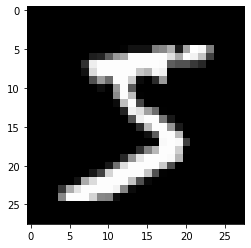

In [24]:
im, label = mnist_train[0]
plt.imshow(im, cmap='gray')
print(im, label)

### Convert to Tensor and A Custom torchvision.transformation for Binarization

In [25]:
class MyBinarization:
    """ convert a gray scale tensor [0, 1] to binary tensor of {0., 1.}"""
    def __init__(self, threshold=0.5):
        self.threshold=threshold
        
    def __call__(self, im):
        bright = im > self.threshold
        im[bright] = 1.
        im[~bright] = 0.
        return im

data_transform = torchvision.transforms.Compose([#transforms.Grayscale(), 
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Lambda(lambda im: (im>0.5).float()), # another way to do binarizaiton
                                     #MyBinarization() ,
                                     torchvision.transforms.Lambda(lambda im: im.reshape(-1)) # 
                                    ])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

(torch.Size([784]), torch.float32, 5, array([0., 1.], dtype=float32), int, 784)

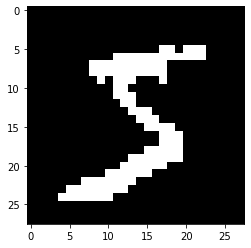

In [26]:
im, label = mnist_train[0]
plt.imshow(im.reshape(28,28), cmap='gray')
im.shape, im.dtype, label, np.unique(im), type(label), 28*28

## Bernoulli Naive Bayes
- https://github.com/dsgiitr/d2l-pytorch/blob/master/Ch04_The_Preliminaries_A_Crashcourse/Naive_Bayes_Classification.ipynb

In [27]:
xcount = torch.ones((im.reshape(-1).shape[0],10)).float()
ycount = torch.ones((10))

for im, label in mnist_train:
    xcount[:,label] += im.reshape(-1)
    ycount[label] += 1
#

In [28]:
py = ycount / ycount.sum()
px = xcount / ycount.unsqueeze(0) # each row is divided by ycount

- For example, px[300,:] shows the Bernoulli probability at the location 300 for the class labels.
- px[300,**k**] is the probability of being a bright pixel at the location 300 provided the class is **k**

In [29]:
px[300,:]

tensor([0.6437, 0.0114, 0.3167, 0.1797, 0.3377, 0.1046, 0.0781, 0.4349, 0.4508,
        0.3057])

Class Conditional Probabilities: 


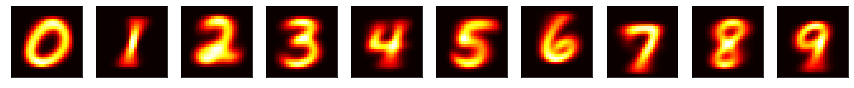

Class Prior Probabilities:
  tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])


In [30]:
fig, axes = plt.subplots(1,10, figsize=(15,10))
print('Class Conditional Probabilities: ')
for i in range(10):
    axes[i].imshow(px[:,i].reshape(28,28).numpy(), cmap='hot')
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
plt.show()
print('Class Prior Probabilities:\n ', py)

* Notice that the images are well aligned within classes.

In [31]:
np.unique(mnist_train.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

## PyTorch Neural Network

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torch.utils
import torch.nn as nn
import torch.optim
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')
print (device)

cuda:0


## Data Preparation

In [33]:
data_transform = torchvision.transforms.Compose([#transforms.Grayscale(), 
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Lambda(lambda im: im.reshape(-1))
                                    ])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

batch_size=4
data_loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

torch.Size([784]) 5


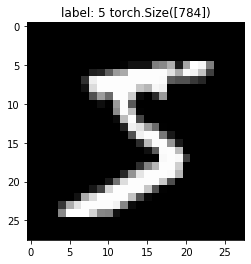

In [34]:
# Explore
im, label = mnist_train[0]

print(im.shape, label)
plt.imshow(im.reshape(28,28), cmap='gray')
plt.title(f'label: {label} {im.shape}');

torch.Size([4, 784])


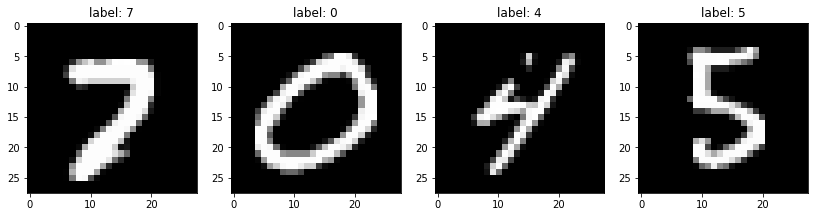

In [35]:
for batch_im, batch_label in data_loader_train:
    print(batch_im.shape)
    fig, axes = plt.subplots(1,batch_im.shape[0], figsize=(14,8))
    for i in range(batch_im.shape[0]):
        axes[i].imshow(batch_im[i].reshape(28,28), cmap='gray')
        axes[i].set_title(f'label: {batch_label[i]}')
    break

### Network Design

In [36]:
# Two hidden layer network

def myNetwork(in_features, n_targget):
    net = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=in_features//2),
        nn.Tanh(),
        nn.Linear(in_features=in_features//2, out_features=n_target),
        nn.LogSoftmax(dim=1)
        )
    return net
#

### Revise the action of `LogSoftMax()`

In [37]:
logsoftmax = nn.LogSoftmax(dim=1)
score_batch = torch.randn((4,10))
lsm = logsoftmax(score_batch) # log softmax along the dimension
print('Score Batch:\n', score_batch)
print('LogSoftMax:\n', lsm)
print('SoftMax:\n', torch.exp(lsm))
print('argmax(dim=1):\n', torch.argmax(lsm, dim=1))

Score Batch:
 tensor([[ 0.8889,  1.8206, -1.5456, -0.6461,  0.0881,  0.4228,  0.8802, -0.6870,
          0.3651, -0.4397],
        [-0.6397,  0.4914,  0.0140, -0.9648, -0.7519,  1.3740,  0.0263, -0.3489,
         -0.4878, -0.9831],
        [-0.6362,  0.3756,  0.6294,  0.3652,  0.4578,  0.9976, -0.3791,  0.1697,
          0.6425,  0.3169],
        [ 0.2714, -1.0590, -0.5096,  0.6449, -0.5089,  0.4441, -1.1427,  0.1341,
          0.7520, -0.8146]])
LogSoftMax:
 tensor([[-1.9422, -1.0104, -4.3766, -3.4771, -2.7429, -2.4082, -1.9508, -3.5180,
         -2.4659, -3.2707],
        [-3.0100, -1.8788, -2.3563, -3.3351, -3.1222, -0.9962, -2.3439, -2.7191,
         -2.8580, -3.3533],
        [-3.3267, -2.3149, -2.0611, -2.3252, -2.2327, -1.6928, -3.0695, -2.5207,
         -2.0480, -2.3735],
        [-2.0658, -3.3962, -2.8468, -1.6923, -2.8461, -1.8931, -3.4799, -2.2031,
         -1.5851, -3.1518]])
SoftMax:
 tensor([[0.1434, 0.3641, 0.0126, 0.0309, 0.0644, 0.0900, 0.1422, 0.0297, 0.0849,
        

### Sanity Check with Dataset

In [38]:
in_features = 28*28
n_target = 10

model = myNetwork(in_features, n_target).to(device)
model, next(model.parameters()).is_cuda

(Sequential(
   (0): Linear(in_features=784, out_features=392, bias=True)
   (1): Tanh()
   (2): Linear(in_features=392, out_features=10, bias=True)
   (3): LogSoftmax()
 ), True)

In [39]:
# net working test
with torch.no_grad():
    for i in range(4):
        print(i, '------------------------------------')
        im_tensor, label = mnist_train[i]
        print(im_tensor.unsqueeze(0).shape)
        yp = model(im_tensor.unsqueeze(0).to(device)) # [Batch, data_features]
        pred = torch.argmax(yp, dim=1)
        print('log_P(y|x): ', yp)
        print('P(y|x): ', torch.exp(yp))
        print('argmax: ', pred.item())

0 ------------------------------------
torch.Size([1, 784])
log_P(y|x):  tensor([[-2.4409, -2.2903, -2.3786, -2.2030, -2.3591, -2.3548, -2.3417, -2.2459,
         -2.2707, -2.1726]], device='cuda:0')
P(y|x):  tensor([[0.0871, 0.1012, 0.0927, 0.1105, 0.0945, 0.0949, 0.0962, 0.1058, 0.1032,
         0.1139]], device='cuda:0')
argmax:  9
1 ------------------------------------
torch.Size([1, 784])
log_P(y|x):  tensor([[-2.2650, -2.4432, -2.5211, -2.1512, -2.1836, -2.2807, -2.3945, -2.4438,
         -2.2238, -2.1939]], device='cuda:0')
P(y|x):  tensor([[0.1038, 0.0869, 0.0804, 0.1163, 0.1126, 0.1022, 0.0912, 0.0868, 0.1082,
         0.1115]], device='cuda:0')
argmax:  3
2 ------------------------------------
torch.Size([1, 784])
log_P(y|x):  tensor([[-2.2762, -2.3133, -2.2713, -2.4366, -2.2337, -2.4687, -2.2780, -2.1659,
         -2.3578, -2.2619]], device='cuda:0')
P(y|x):  tensor([[0.1027, 0.0989, 0.1032, 0.0875, 0.1071, 0.0847, 0.1025, 0.1146, 0.0946,
         0.1042]], device='cuda:0')


### Sanity Check with data_loader

In [40]:
with torch.no_grad():
    for im_batch, label_batch in data_loader_train:
        im_batch, label_batch = im_batch.to(device), label_batch.to(device)
        print(im_batch.shape, im_batch.dtype, label_batch.shape)
        yp = model(im_batch) # [Batch, data_features]
        pred = torch.argmax(yp, dim=1)
        print('log_P(y|x):\n', yp)
        print ('P(y|x): ', torch.exp(yp))
        print('argmax: ', pred)
        break

torch.Size([4, 784]) torch.float32 torch.Size([4])
log_P(y|x):
 tensor([[-2.4069, -2.1494, -2.3790, -2.3367, -2.2031, -2.2688, -2.3906, -2.3379,
         -2.3212, -2.2643],
        [-2.4554, -2.2421, -2.3067, -2.2948, -2.2741, -2.3709, -2.3407, -2.3046,
         -2.2854, -2.1760],
        [-2.2570, -2.3164, -2.4937, -2.1927, -2.2483, -2.3524, -2.3553, -2.2832,
         -2.2161, -2.3443],
        [-2.3601, -2.2152, -2.4754, -2.3249, -2.2697, -2.3144, -2.3267, -2.2326,
         -2.3732, -2.1689]], device='cuda:0')
P(y|x):  tensor([[0.0901, 0.1166, 0.0926, 0.0966, 0.1105, 0.1034, 0.0916, 0.0965, 0.0982,
         0.1039],
        [0.0858, 0.1062, 0.0996, 0.1008, 0.1029, 0.0934, 0.0963, 0.0998, 0.1017,
         0.1135],
        [0.1047, 0.0986, 0.0826, 0.1116, 0.1056, 0.0951, 0.0949, 0.1020, 0.1090,
         0.0959],
        [0.0944, 0.1091, 0.0841, 0.0978, 0.1033, 0.0988, 0.0976, 0.1073, 0.0932,
         0.1143]], device='cuda:0')
argmax:  tensor([1, 9, 3, 9], device='cuda:0')


### Training Loop

In [41]:
from training_loop import training_loop, performance, plot_history

### Increase batch_size

In [42]:
batch_size=128
data_loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

### optimizer & loss_function

In [43]:
model = myNetwork(in_features, n_target).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.NLLLoss().to(device)

In [45]:
history = training_loop(n_epochs=10,
                        optim=optimizer,
                        model=model,
                        loss_fn=loss_fn, 
                        dl_train=data_loader_train,
                        dl_val = data_loader_test,
                        device=device
                        )

Epoch 1, tloss 1.42 t_acc: 0.73  vloss 0.83  v_acc: 0.84
Epoch 2, tloss 0.68 t_acc: 0.85  vloss 0.54  v_acc: 0.87
Epoch 3, tloss 0.51 t_acc: 0.87  vloss 0.45  v_acc: 0.89
Epoch 4, tloss 0.44 t_acc: 0.88  vloss 0.40  v_acc: 0.89
Epoch 5, tloss 0.41 t_acc: 0.89  vloss 0.37  v_acc: 0.90
Epoch 10, tloss 0.33 t_acc: 0.91  vloss 0.32  v_acc: 0.91
finished training_loop().ated at epoch 10: 0.9127.


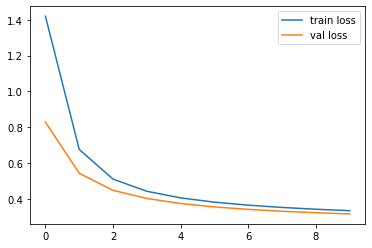

In [46]:
plt.plot(history['tloss'], label='train loss')
plt.plot(history['vloss'], label='val loss')
plt.legend();

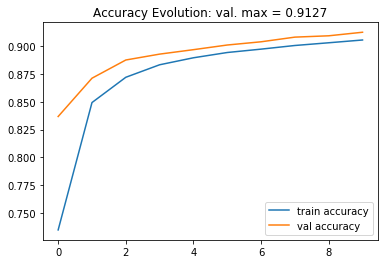

In [48]:
vmax = max(history['vacc'])
plt.title(f'Accuracy Evolution: val. max = {vmax}')
plt.plot(history['tacc'], label='train accuracy')
plt.plot(history['vacc'], label='val accuracy')
plt.legend();

### Do some more training

In [50]:
history = training_loop(n_epochs=50,
                        optim=optimizer,
                        model=model,
                        loss_fn=loss_fn, 
                        dl_train=data_loader_train,
                        dl_val = data_loader_test,
                        hist=history,
                        device=device)

Epoch 1, tloss 0.33 t_acc: 0.91  vloss 0.31  v_acc: 0.91
Epoch 2, tloss 0.32 t_acc: 0.91  vloss 0.31  v_acc: 0.92
Epoch 3, tloss 0.32 t_acc: 0.91  vloss 0.30  v_acc: 0.92
Epoch 4, tloss 0.31 t_acc: 0.91  vloss 0.30  v_acc: 0.92
Epoch 5, tloss 0.31 t_acc: 0.91  vloss 0.29  v_acc: 0.92
Epoch 50, tloss 0.20 t_acc: 0.94  vloss 0.21  v_acc: 0.94
finished training_loop().ated at epoch 50: 0.9412.


In [51]:
def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(16,6))
    axes[0].set_title('Loss'); 
    axes[0].plot(history['tloss'], label='train'); axes[0].plot(history['vloss'], label='val')
    axes[0].legend()
    axes[1].set_title('Acc: vmax = '+str(max(history['vacc'])))
    axes[1].plot(history['tacc'], label='train'); axes[1].plot(history['vacc'], label='val')
    axes[1].legend()

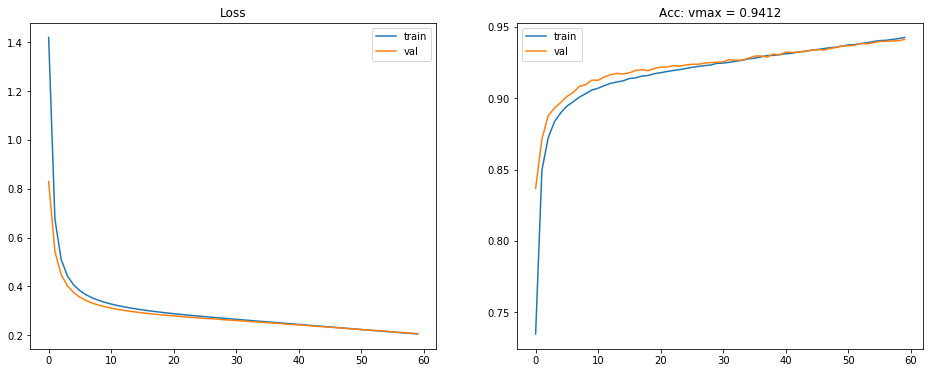

In [52]:
plot_history(history)

Epoch 1, tloss 0.20 t_acc: 0.94  vloss 0.20  v_acc: 0.95
Epoch 2, tloss 0.20 t_acc: 0.95  vloss 0.20  v_acc: 0.94
Epoch 3, tloss 0.19 t_acc: 0.95  vloss 0.19  v_acc: 0.94
Epoch 4, tloss 0.19 t_acc: 0.95  vloss 0.19  v_acc: 0.95
Epoch 5, tloss 0.19 t_acc: 0.95  vloss 0.19  v_acc: 0.95
Epoch 250, tloss 0.05 t_acc: 0.99  vloss 0.08  v_acc: 0.98
finished training_loop().


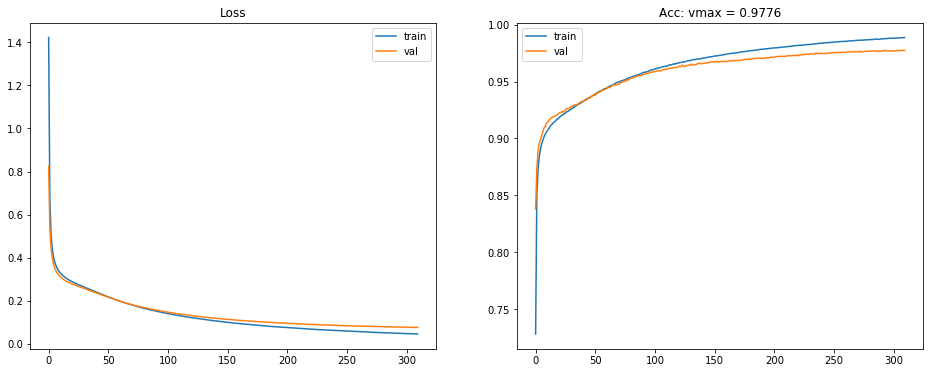

In [29]:
history = training_loop(n_epochs=250,
                        optim=optimizer,
                        model=model,
                        loss_fn=loss_fn, 
                        dl_train=data_loader_train,
                        dl_val = data_loader_test,
                        hist=history)
plot_history(history)

### Practicums
- Modify batch_size to examine the behavior of the training loop.
- Try other values of learning_rate
- Try Adam
    - what is Adam by the way?